# Driving Behavior Analysis

The dataset contains information about driver behavior metrics and includes a column that classifies the behavior into three categories:
- **Normal**
- **Aggressive**
- **Slow**

The goal of this analysis is to develop machine learning models that can predict the categorization based on the driving behavior metrics.


In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Loading the Datasets and basic transformations

Separate training and test files have already been provided. Initially, I will use these files as intended to train and evaluate the model. Later on, I will merge the datasets and use all the data for training with **KFold cross-validation** to see if it improves the model's performance.

The timestamp column was removed as it doesn't provide valueable information and caused the model to become almost 100% accurate.

In [2]:
train_url = "https://raw.githubusercontent.com/GitJvG/Dataset/main/train_motion_data.csv"
test_url = "https://raw.githubusercontent.com/GitJvG/Dataset/main/test_motion_data.csv"

trainDF = pd.read_csv(train_url)
testDF = pd.read_csv(test_url)

# Convert 'Class' to categorical type
catType = CategoricalDtype(categories=['AGGRESSIVE', "NORMAL", "SLOW"], ordered=True)
trainDF['Class'] = trainDF['Class'].astype(catType)
testDF['Class'] = testDF['Class'].astype(catType)

# Select the columns to be used for the scatter matrix (AccX, AccY, AccZ, GyroX, GyroY, GyroZ)
excluded = ["Class", "Timestamp"]
train_features = trainDF.drop(excluded, axis=1)
test_features = testDF.drop(excluded, axis=1)

# Basic reusable function to quickly test models

To reduce redundancy and be able to more easily compare different models, I made a basic function that can will spit out a **confusion_matrix** and **classification_report**

In [ ]:
def test_model(Model, Xtrain, Ytrain, Xtest, Ytest):
    Model.fit(Xtrain,Ytrain) #Fit the model
    Model.score(Xtest,Ytest) #Determine the score of the model
    
    Model_Prediction = Model.predict(Xtest)
    accuracy = Model.score(Xtest, Ytest)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(Ytest, Model_Prediction, labels=Model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Model.classes_)
    disp.plot()
    plt.show()

    # Print classification report to check the classification performance
    print(classification_report(Ytest, Model_Prediction, target_names=Model.classes_))

# Getting some insight into the dataset

Just to get a sense for the data, I generate a scatterplot matrix to see if any of the values are strongly correlated. 

This doesn't seem to be the case.

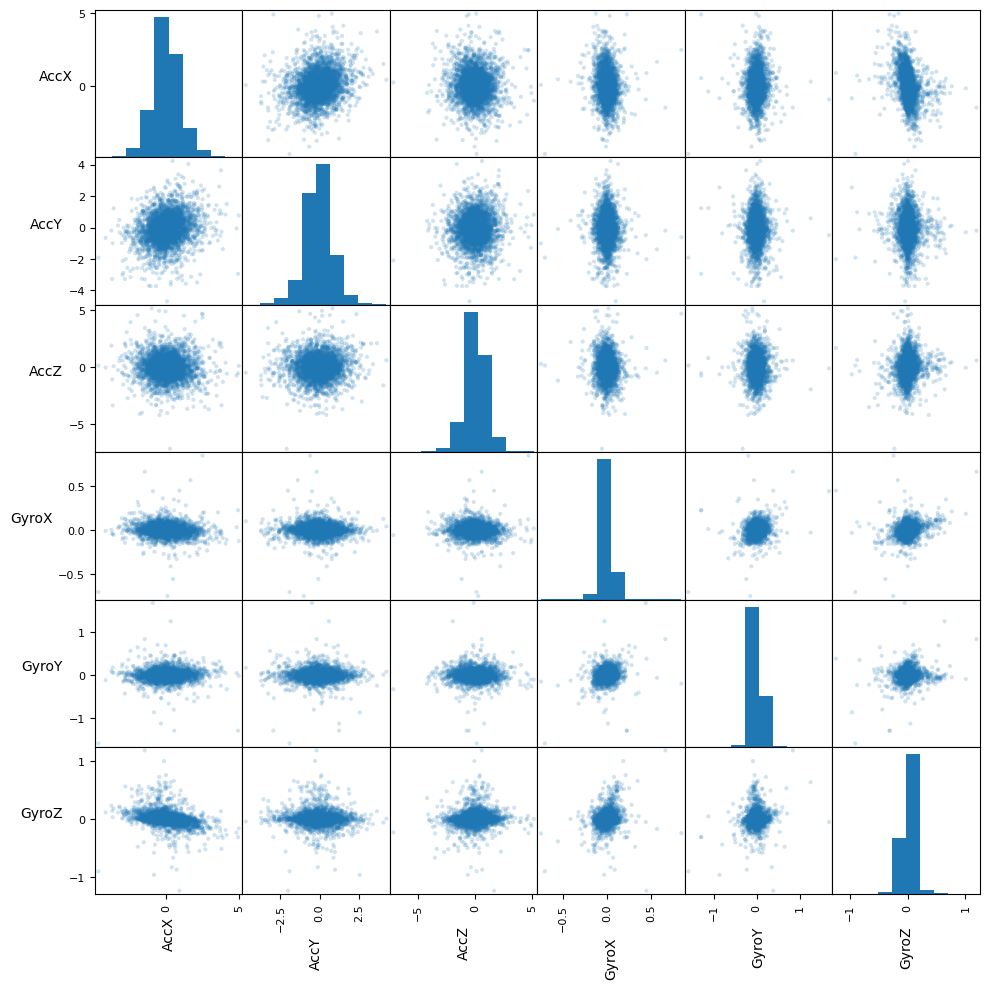

In [3]:
fig = scatter_matrix(train_features, alpha=0.2, figsize=(10, 10), diagonal="hist")

# Customize the scatter matrix plot
for ax in fig.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

# Preparing data for training models

This step includes normalizing the data. I chose to also make all values absolute (turning all values into positive values) because I want to measure the extremity of the value, not whether it was positive or negative. This also improved the model's accuracy.

In [4]:
def absolute_normalize(x):
    abs_x = x.abs()  # Convert values to their absolute values
    return (abs_x - abs_x.min()) / (abs_x.max() - abs_x.min())  # Normalize the absolute values

X_train = train_features.apply(absolute_normalize, axis=0)
X_test = test_features.apply(absolute_normalize, axis=0)

y_train = trainDF["Class"]
y_test = testDF["Class"]

# Running models

In the following block of code I will test several different models using the previously defined function.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)
test_model(knn, X_train, y_train, X_test, y_test)

RFC=RandomForestClassifier()
test_model(RFC, X_train, y_train, X_test, y_test)

GBC = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
test_model(GBC, X_train, y_train, X_test, y_test)

SVC1 = SVC(kernel='rbf', C=1, gamma='auto')
test_model(SVC1, X_train, y_train, X_test, y_test)

"""Best accuracy score so far but the model clearly still sucks and only returns a high score because there a more slow cases."""

"""Attempting to improve the model with extra parameters"""
SVC2 = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced', )
test_model(SVC2, X_train, y_train, X_test, y_test)